# HPA Gene Page AI Summaries

In [ ]:
import pandas as pd
import json
from plotnine import *
import collections
from extract_data import extract_multiple_genes

## Extract Data

- Import gene ENSEMBLE IDs from HPA.
- For each gene ID, parse the corresponding HPA gene page and store it in JSON.

In [2]:
hpa_df = pd.read_csv("../data/hpa_genes.tsv", sep="\t")
hpa_genes = hpa_df.iloc[:, 0].tolist()

print(f"Loaded {len(hpa_genes)} genes from HPA file.")

Loaded 20162 genes from HPA file.


In [ ]:
# Extract data for all genes
'''if __name__ == "__main__":
    ensembl_ids = hpa_genes
    summaries = extract_multiple_genes(ensembl_ids)
    # Save to file
    with open("../data/gene_data.json", "w") as f:
        json.dump(summaries, f, indent=2)
        
    print(json.dumps(summaries, indent=2))'''

'if __name__ == "__main__":\n    ensembl_ids = hpa_genes\n    summaries = extract_multiple_genes(ensembl_ids)\n    # Save to file\n    with open("../data/gene_data.json", "w") as f:\n        json.dump(summaries, f, indent=2)\n\n    for gene_json in summaries.values():\n        if "HUMAN PROTEIN ATLAS INFORMATION (brain)" in gene_json:\n            gene_json["Brain"] = gene_json.pop("HUMAN PROTEIN ATLAS INFORMATION (brain)")\n        if "HUMAN PROTEIN ATLAS INFORMATION (blood)" in gene_json:\n            gene_json["Blood"] = gene_json.pop("HUMAN PROTEIN ATLAS INFORMATION (blood)")\n\n    print(json.dumps(summaries, indent=2))'

## Exploratory Data Analysis

### Analyze all genes to identify distributions

In [4]:
with open("../data/gene_data_sub.json") as f:
    gene_data = json.load(f)
    
print(f"Loaded data for {len(gene_data)} genes from JSON file.")

Loaded data for 78 genes from JSON file.


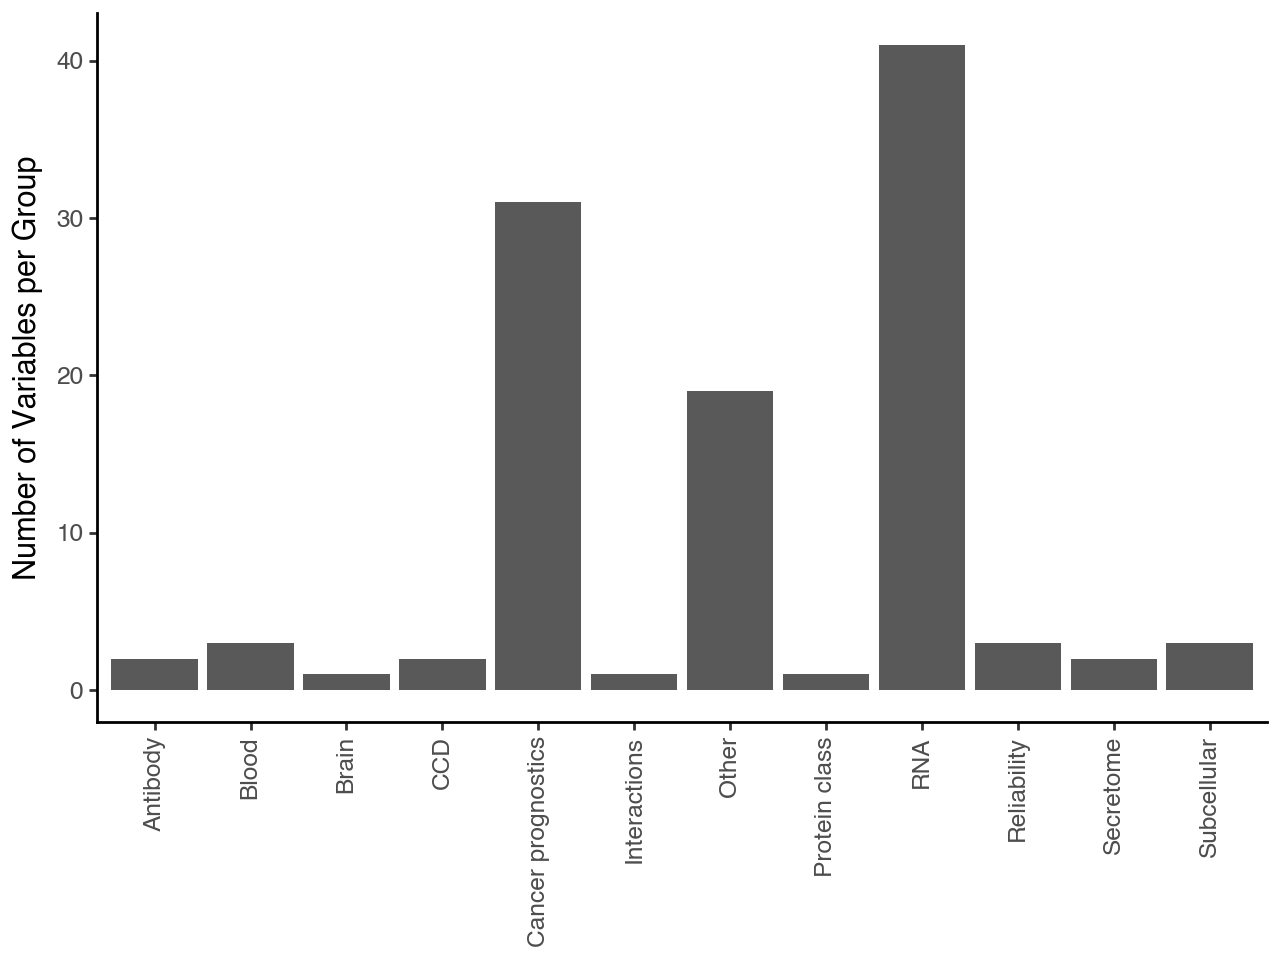

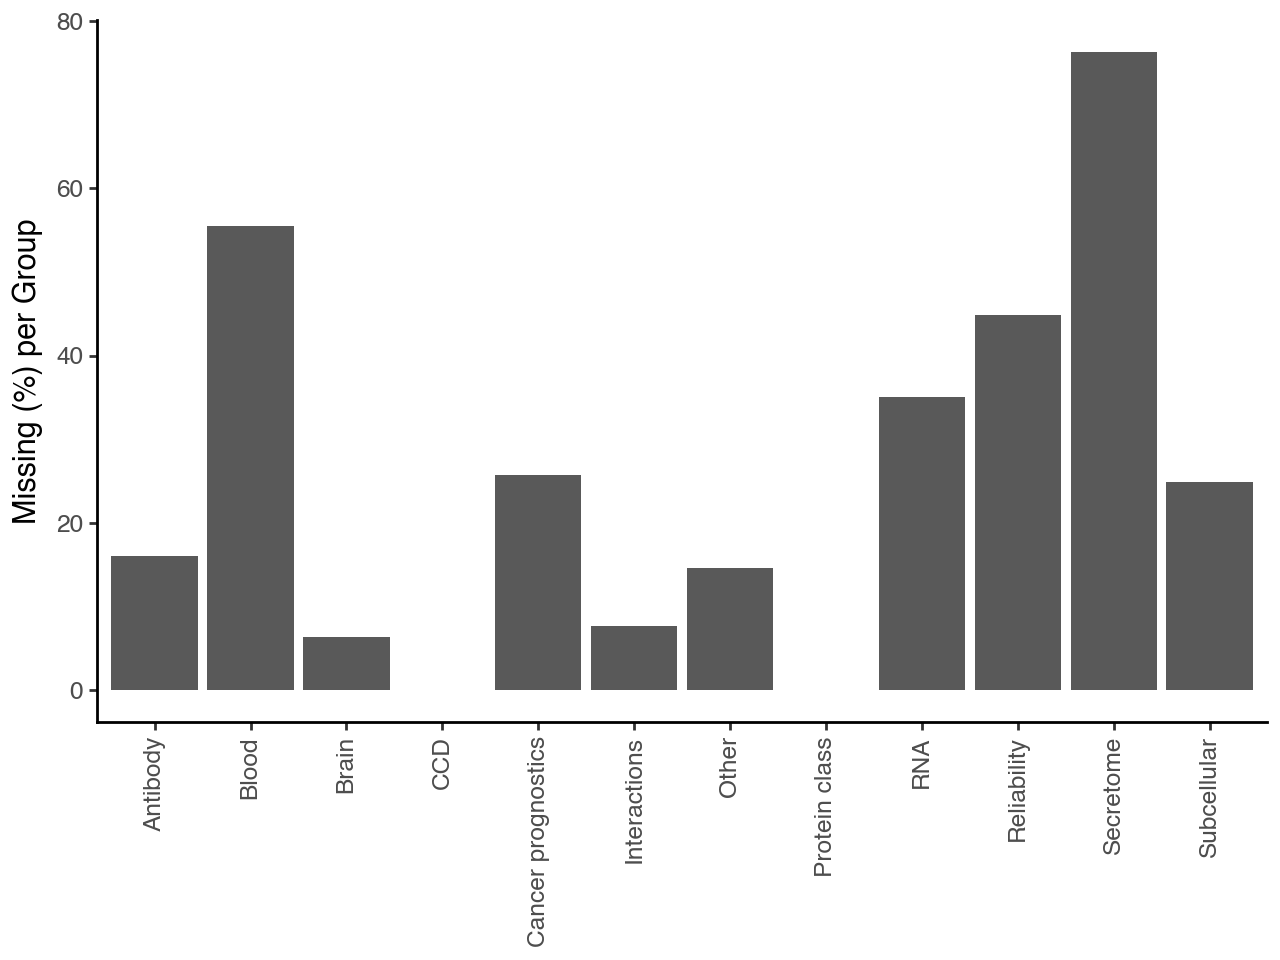

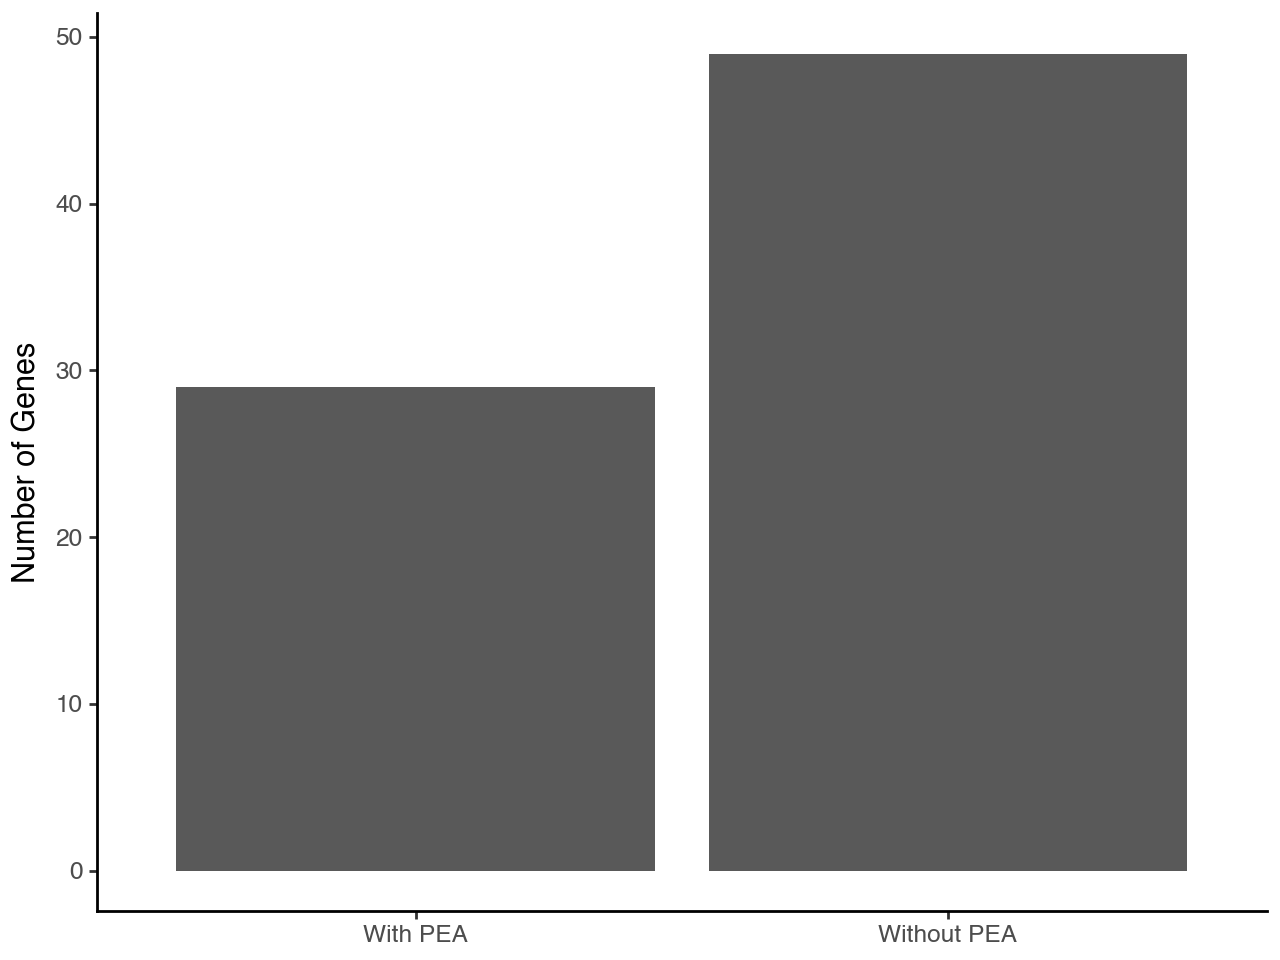

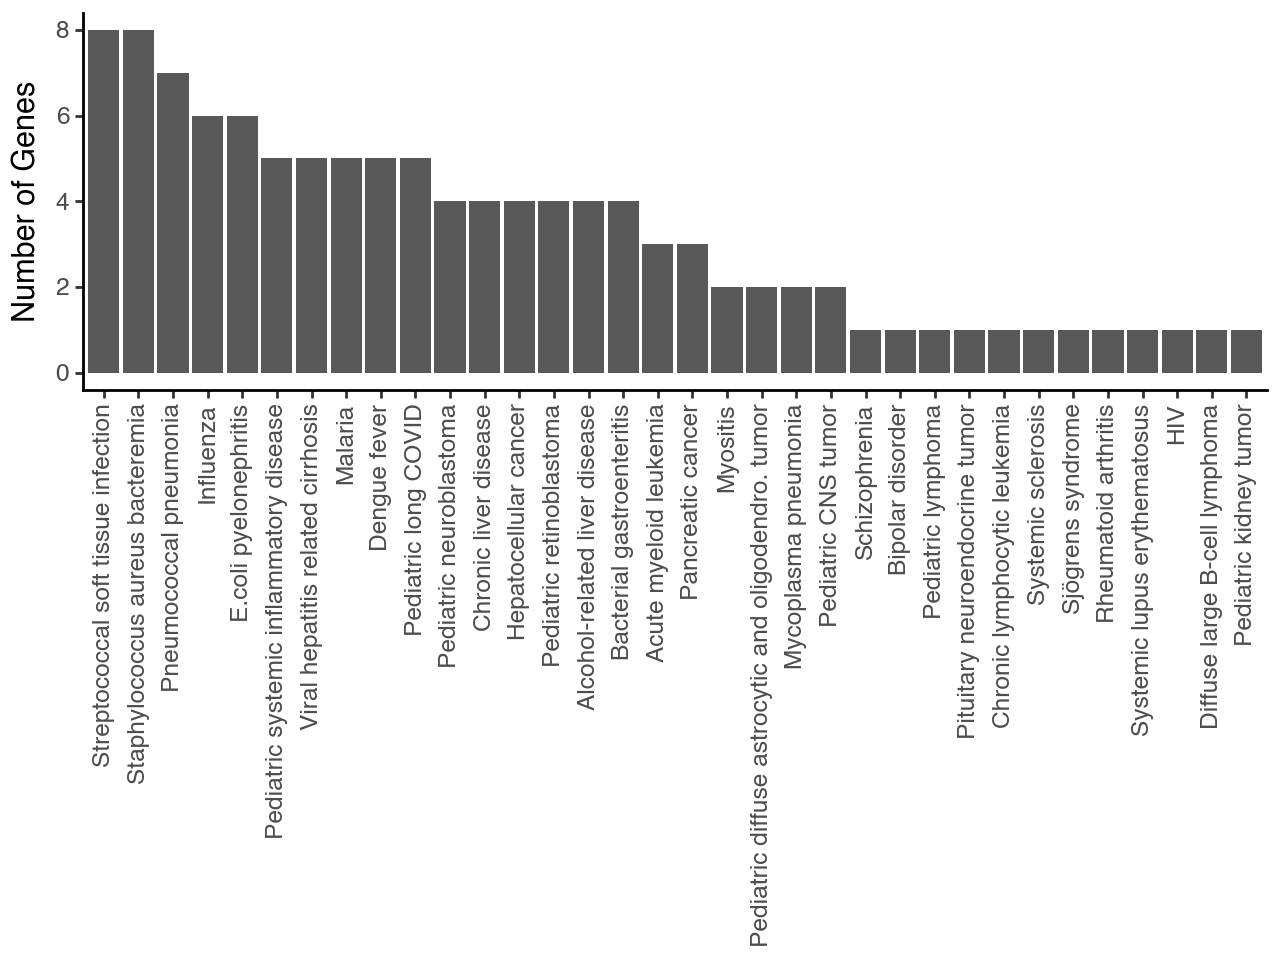

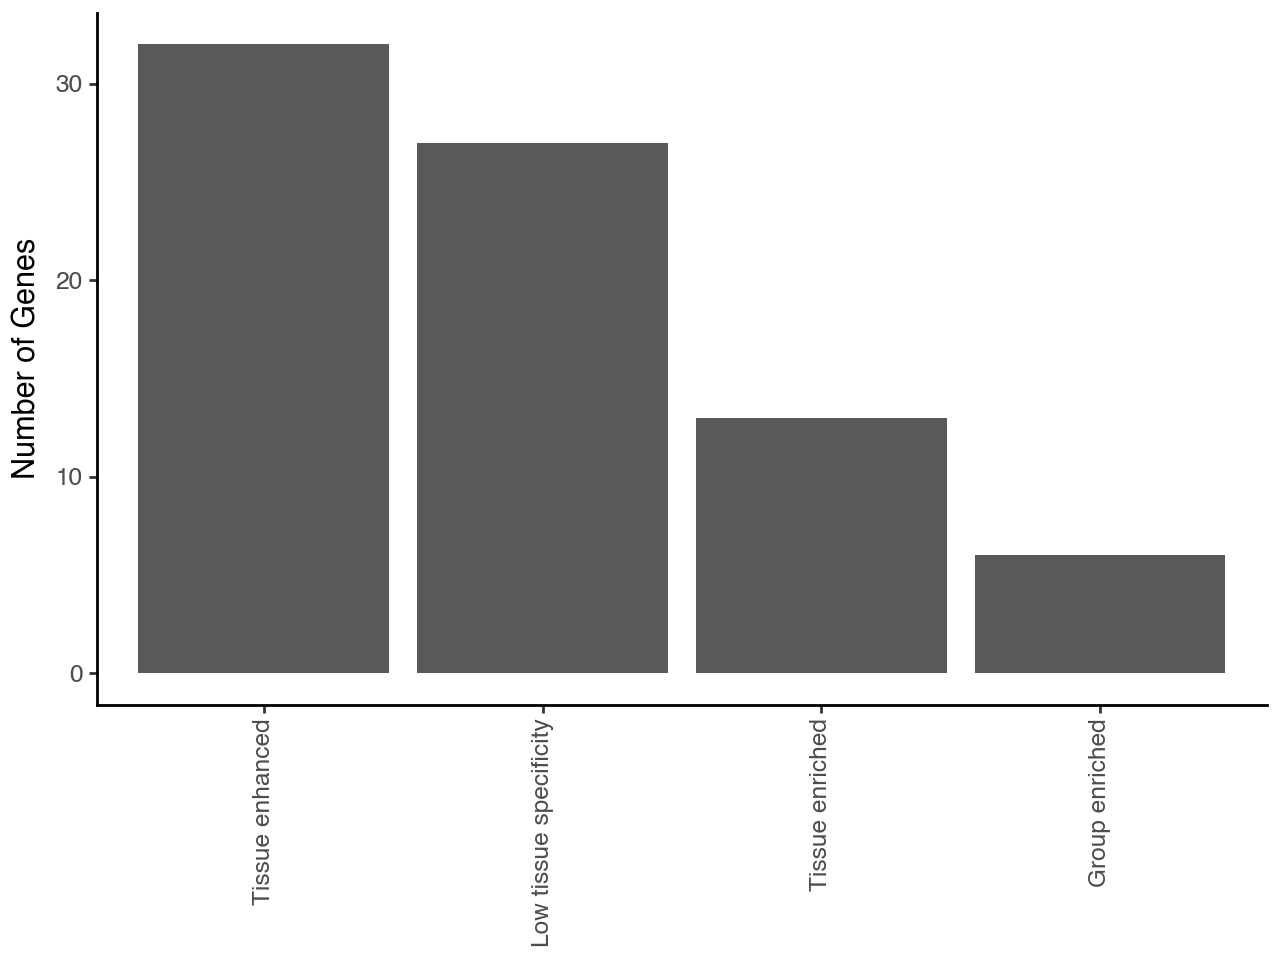

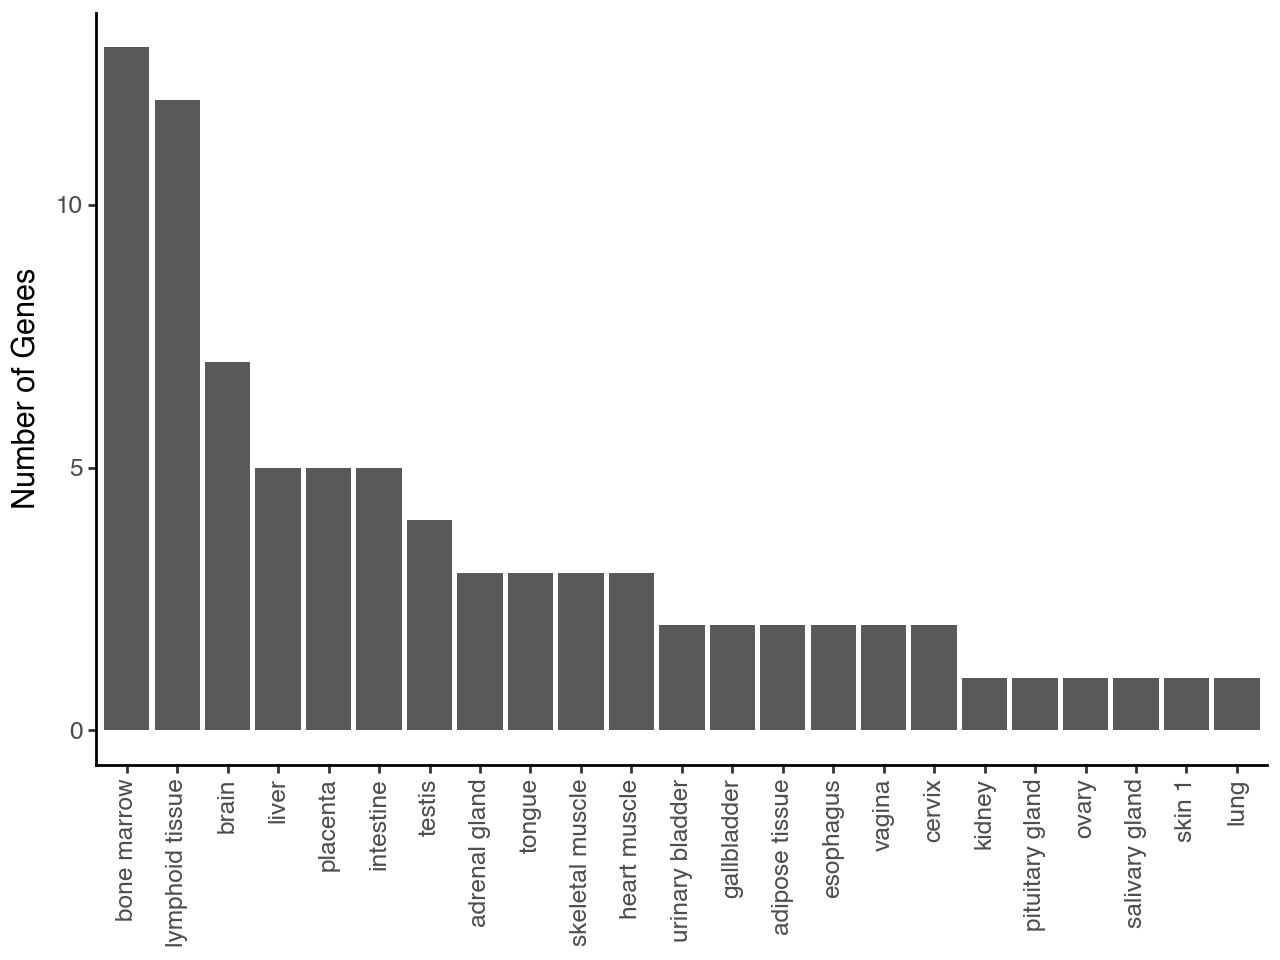

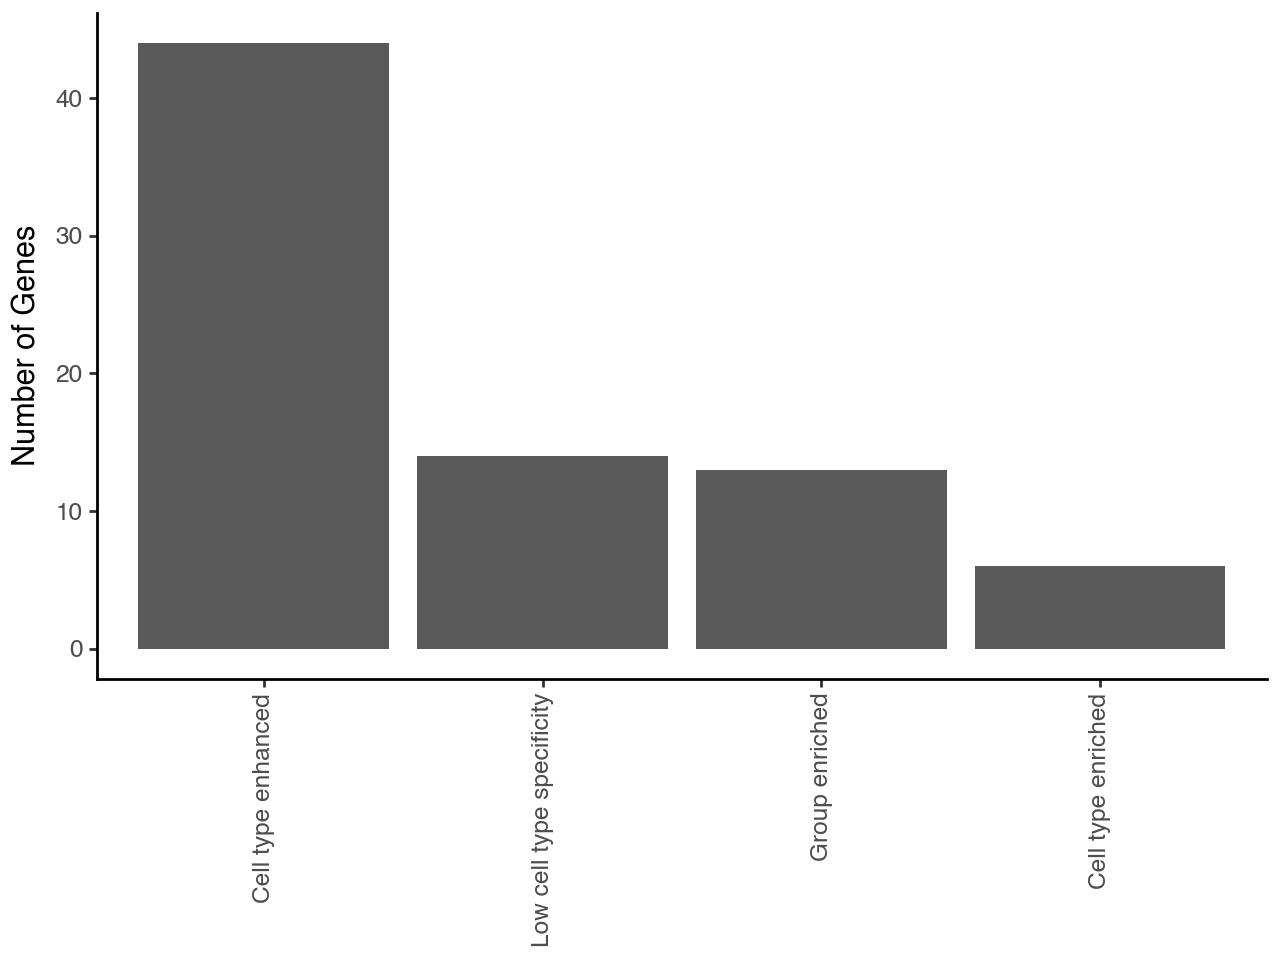

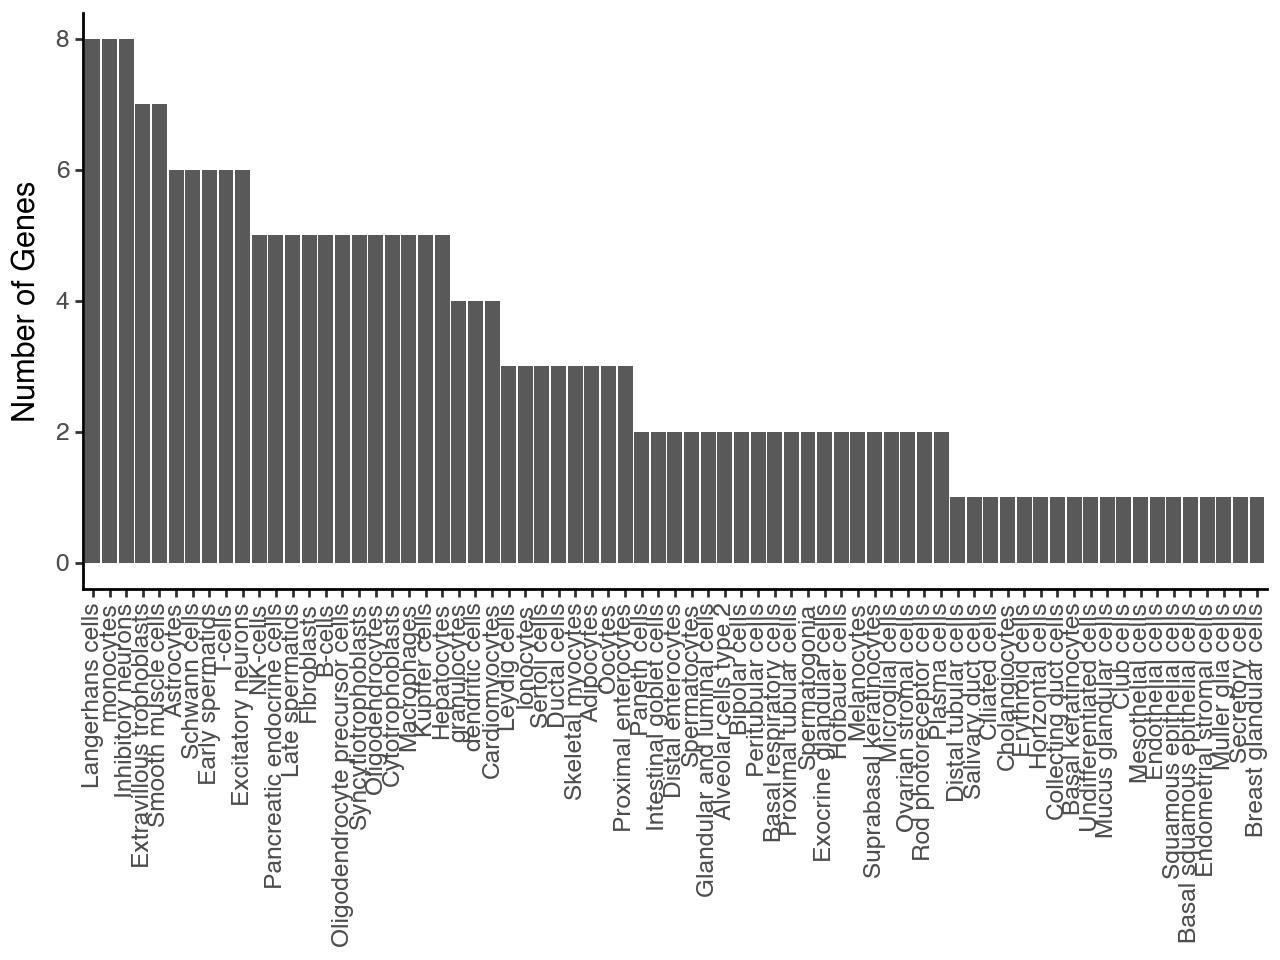

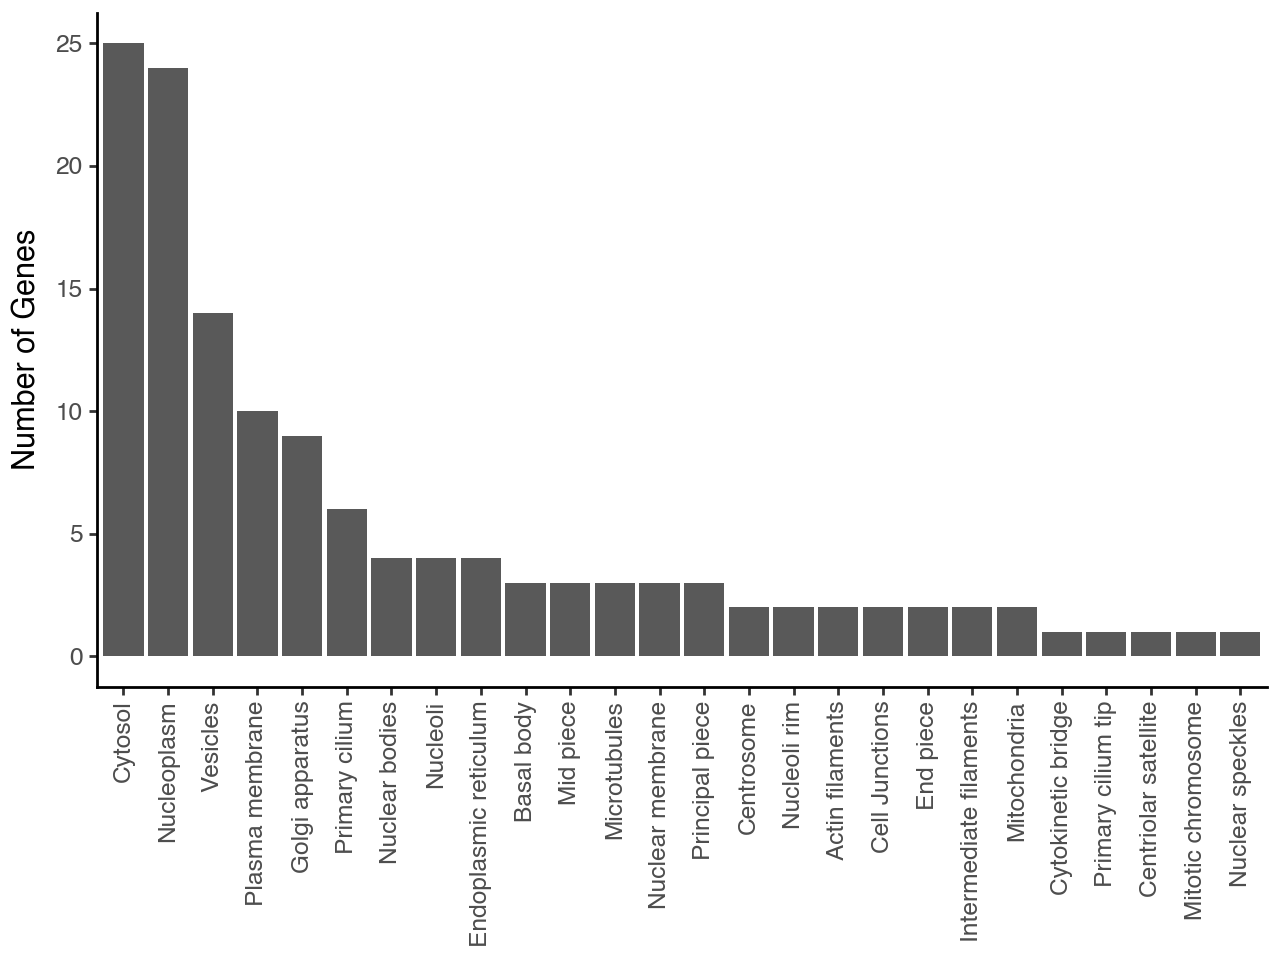

In [17]:
def flatten_values(val):
    """Recursively flatten lists/dicts to final values."""
    if isinstance(val, dict):
        vals = []
        for v in val.values():
            vals.extend(flatten_values(v))
        return vals
    elif isinstance(val, list):
        vals = []
        for v in val:
            vals.extend(flatten_values(v))
        return vals
    else:
        return [val]

def get_group(field):
    """Group fields by prefix."""
    if field.startswith("RNA"):
        return "RNA"
    elif field.startswith("Cancer prognostics"):
        return "Cancer prognostics"
    elif field.startswith("Blood"):
        return "Blood"
    elif field.startswith("Brain"):
        return "Brain"
    elif field.startswith("Antibody"):
        return "Antibody"
    elif field.startswith("Reliability"):
        return "Reliability"
    elif field.startswith("Subcellular"):
        return "Subcellular"
    elif field.startswith("Secretome"):
        return "Secretome"
    elif field.startswith("CCD"):
        return "CCD"
    elif field.startswith("Protein class"):
        return "Protein class"
    elif field.startswith("Interactions"):
        return "Interactions"
    else:
        return "Other"

# Count unique fields per group
group_fields = collections.defaultdict(set)
for g in gene_data.values():
    for field in g.keys():
        group = get_group(field)
        group_fields[group].add(field)

# Prepare DataFrame
group_var_counts = pd.DataFrame([
    {"group": group, "num_variables": len(fields)}
    for group, fields in group_fields.items()
])

# Plot number of variables per group
p_vars = (
    ggplot(group_var_counts, aes(x="group", y="num_variables")) +
    geom_bar(stat="identity") +
    labs(x="", y="Number of Variables per Group") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_vars.show()

missing_counter = collections.defaultdict(int)
total_counter = collections.defaultdict(int)

for g in gene_data.values():
    for field, val in g.items():
        group = get_group(field)
        values = flatten_values(val)
        for v in values:
            total_counter[group] += 1
            if v is None or v == "" or v == [] or v == {} or v == "None" or v == "Not detected" or v == "Not analysed":
                missing_counter[group] += 1

# Calculate percentage missingness
missingness = []
for group in total_counter:
    percent = 100 * missing_counter[group] / total_counter[group] if total_counter[group] > 0 else 0
    missingness.append({"group": group, "missing_pct": percent})

missing_df = pd.DataFrame(missingness)

# Plot
p = (
    ggplot(missing_df, aes(x="group", y="missing_pct")) +
    geom_bar(stat="identity") +
    labs(x="", y="Missing (%) per Group") +
    theme_classic() +
    theme(legend_position="none", axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.show()

# PEA disease counts
pea_with = 0
pea_without = 0

for g in gene_data.values():
    blood_info = g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {})
    pea_status = blood_info.get("Proximity extension assay", "")
    if "Data available" in pea_status:
        pea_with += 1
    else:
        pea_without += 1

pea_df = pd.DataFrame({
    "PEA data": ["With PEA", "Without PEA"],
    "Count": [pea_with, pea_without]
})

p_pea = (
    ggplot(pea_df, aes(x="PEA data", y="Count")) +
    geom_bar(stat="identity") +
    labs(x="", y="Number of Genes") +
    theme_classic()
)
p_pea.show()

# Collect diseases for genes with PEA data
disease_counter = collections.Counter()
for g in gene_data.values():
    blood_info = g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {})
    pea_status = blood_info.get("Proximity extension assay", "")
    if "Data available" in pea_status:
        diseases = blood_info.get("Upregulated in disease", "")
        if diseases and diseases.lower() != "not analyzed" and diseases.lower() != "no":
            for disease in diseases.split(","):
                disease_counter[disease.strip()] += 1

# Prepare DataFrame for plotting
disease_df = pd.DataFrame({
    "Disease": list(disease_counter.keys()),
    "Count": list(disease_counter.values())
}).sort_values("Count", ascending=False)

disease_order = disease_df["Disease"].tolist()

p_disease = (
    ggplot(disease_df, aes(x="Disease", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=disease_order) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_disease.show()

# Tissue counts
tissue_specificity_counter = collections.Counter()
tissue_ntpm_counter = collections.Counter()

for g in gene_data.values():
    # RNA tissue specificity
    spec = g.get('RNA tissue specificity', None)
    if spec and spec.lower() != "not detected":
        tissue_specificity_counter[spec] += 1
    # RNA tissue specific nTPM
    ntpm = g.get('RNA tissue specific nTPM', {})
    if isinstance(ntpm, dict):
        for tissue in ntpm:
            tissue_ntpm_counter[tissue] += 1

# Plot tissue specificity
df_tissue_spec = pd.DataFrame({
    "Specificity": list(tissue_specificity_counter.keys()),
    "Count": list(tissue_specificity_counter.values())
}).sort_values("Count", ascending=False)
order_tissue_spec = df_tissue_spec["Specificity"].tolist()

p_tissue_spec = (
    ggplot(df_tissue_spec, aes(x="Specificity", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_tissue_spec) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_tissue_spec.show()

# Plot tissues
df_tissue_ntpm = pd.DataFrame({
    "Tissue": list(tissue_ntpm_counter.keys()),
    "Count": list(tissue_ntpm_counter.values())
}).sort_values("Count", ascending=False)
order_tissue_ntpm = df_tissue_ntpm["Tissue"].tolist()

p_tissue_ntpm = (
    ggplot(df_tissue_ntpm, aes(x="Tissue", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_tissue_ntpm) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_tissue_ntpm.show()

# Cell type counts
celltype_specificity_counter = collections.Counter()
celltype_ntpm_counter = collections.Counter()

for g in gene_data.values():
    # RNA single cell type specificity
    spec = g.get('RNA single cell type specificity', None)
    if spec and spec.lower() != "not detected":
        celltype_specificity_counter[spec] += 1
    # RNA single cell type specific nTPM
    ntpm = g.get('RNA single cell type specific nTPM', {})
    if isinstance(ntpm, dict):
        for celltype in ntpm:
            celltype_ntpm_counter[celltype] += 1

# Plot cell type specificity
df_celltype_spec = pd.DataFrame({
    "Specificity": list(celltype_specificity_counter.keys()),
    "Count": list(celltype_specificity_counter.values())
}).sort_values("Count", ascending=False)
order_celltype_spec = df_celltype_spec["Specificity"].tolist()

p_celltype_spec = (
    ggplot(df_celltype_spec, aes(x="Specificity", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_celltype_spec) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_celltype_spec.show()

# Plot cell types
df_celltype_ntpm = pd.DataFrame({
    "Cell Type": list(celltype_ntpm_counter.keys()),
    "Count": list(celltype_ntpm_counter.values())
}).sort_values("Count", ascending=False)
order_celltype_ntpm = df_celltype_ntpm["Cell Type"].tolist()

p_celltype_ntpm = (
    ggplot(df_celltype_ntpm, aes(x="Cell Type", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_celltype_ntpm) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_celltype_ntpm.show()

# Subcellular location
subcellular_counter = collections.Counter()
for g in gene_data.values():
    locations = g.get('Subcellular location', [])
    if isinstance(locations, list):
        for loc in locations:
            subcellular_counter[loc] += 1

df_subcellular = pd.DataFrame({
    "Location": list(subcellular_counter.keys()),
    "Count": list(subcellular_counter.values())
}).sort_values("Count", ascending=False)
order_subcellular = df_subcellular["Location"].tolist()

p_subcellular = (
    ggplot(df_subcellular, aes(x="Location", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_subcellular) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_subcellular.show()